<h1>Helvar Starter Kit</h1>
<h3>Welcome to Helvar's Junction Challenge!</h3>
<p>This notebook is to help you get acquainted with the dataset. You can follow the instructions to easily load and visualize datasets. However, this is only for convenience purposes. You are welcome to use whatever tools you are comfortable with, as we are only interested in results!</p>
<p>Let's Begin by first loading all necessary libraries for this notebook to run.</p>

In [788]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import base64
import imageio as iio
from plotting import Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import collections
import pymc3 as pm
from scipy.stats import poisson
from fancyimpute import SoftImpute, KNN
import random
import math
import mplcursors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<p>This starter kit contains sample datafiles. You can also download the full datasets in the README document. Please remember to place the downloaded zip file in the data folder and unzip it.</p>
<ol>
<li>First load the pickle file and convert the timestamps to Helsinki timezone</li>
<li>Next load the json file containing deviceids</li>
<li>Finally load the png file as both a numpy array and a base64 encoded image. We need the later for plotting in Plotly helper functions</li>
</ol>

In [7]:
site = 'site_1'

In [46]:
df_events = pd.read_pickle(f'./data/{site}/{site}.pkl', compression='gzip')
# sort by timestamp

df_events.loc[:, 'timestamp'] = (pd.to_datetime(df_events['timestamp'], utc=True)
                                 .dt.tz_convert('Europe/Helsinki')
                                 .dt.tz_localize(None))

df_events = df_events.drop_duplicates().sort_values('timestamp').set_index('timestamp', drop=True)
df_events.head(20)

,deviceid
timestamp,
2021-05-05 00:04:02.125906,30
2021-05-05 00:04:42.353613,30
2021-05-05 00:17:04.806133,30
2021-05-05 00:17:50.081664,30
2021-05-05 00:18:51.596895,30
2021-05-05 00:19:32.048607,30
2021-05-05 00:38:04.081070,30
2021-05-05 00:38:44.579742,30
2021-05-05 00:55:52.924979,30


In [416]:
SECONDS = 60
TIMEPOINTS = SECONDS * 4

In [417]:
prev = collections.deque()
arr = np.zeros((len(devices), len(devices), TIMEPOINTS), dtype='int32')
for t, device in df_events.iterrows():
    device = device[0]
    i = 0
    seen = set()
    while i < len(prev):
        p, pDevice = prev[i]
        distance = (t - p).delta // 250000000
        if distance >= 240:
            prev.popleft()
            continue
        seen.add(pDevice)
        arr[(device, pDevice, distance)] += 1
        arr[(pDevice, device, distance)] += 1
        i += 1
    prev.append((t, device))


In [435]:
data = arr[41, 19, :]
time = np.arange(0, 240)
mean = np.mean(data)

In [625]:
distances = np.zeros((len(devices), len(devices)), dtype='float32') - 1
confidence = np.zeros((len(devices), len(devices)), dtype='float32') - 1
for mainDevice in devices:
    for device in devices:
        data = arr[device, mainDevice, :]
        m = np.max(data)
        mad = robust.mad(data)
        mean = np.mean(data)
        
        if m < 10:
            continue
        deviations = np.sum(poisson.logsf(data, mu=mean))
        if mainDevice == device:
            continue
        if deviations < -500: 
            if mainDevice == 5:
                print(device)
                print(data)
                print(deviations)
            confidence[device, mainDevice] = deviations
            confidence[mainDevice, device] = deviations
            
            distances[device, mainDevice] = np.argmax(data)
            distances[mainDevice, device] = np.argmax(data)            

In [794]:
positions = np.zeros((len(devices), 2), dtype='float32')
positions.fill(np.nan)
positions[0, :] = (0, 0)
for i in range(10):
    for device in devices:
        if np.isnan(positions[device, 0]):
            local_distances = distances[device, :]
            if np.all(local_distances == -1):
                continue
            other_devices = np.where(local_distances != -1)

            for other_device in np.nditer(other_devices):
                if other_device == device:
                    continue
                if np.isnan(positions[other_device, 0]):
                    continue
                break
            else:
                continue
            distance = local_distances[other_device] + 1
            theta = random.uniform(0, 2 * math.pi)

            positions[device, 0] = positions[other_device, 0] + distance * math.cos(theta)
            positions[device, 1] = positions[other_device, 1] + distance * math.sin(theta)
positions

array([[   0.        ,    0.        ],
       [  -7.9324965 ,   -1.0370611 ],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       [ 218.96129   ,  -40.442196  ],
       [ -27.745737  ,  -27.407555  ],
       [  54.01165   , -151.66985   ],
       [  -8.12193   ,   16.063444  ],
       [          nan,           nan],
       [ 148.88013   ,  -35.266212  ],
       [  42.44216   ,   -0.25712568],
       [  41.84018   ,   -1.0556351 ],
       [  41.648335  ,   -0.86527044],
       [  42.26034   ,   -1.2404575 ],
       [  42.784687  ,   -1.1966337 ],
       [  23.117876  ,   19.119722  ],
       [          nan,           nan],
       [  49.77388   , -127.47652   ],
       [ 114.95822   ,  -11.332697  ],
       [ 128.13348   ,   16.617313  ],
       [ 127.616745  ,   17.473457  ],
       [          nan,   

In [759]:
def calculate_distance(device_position, device):
    known_distances = np.where(distances[device, :] != -1)
    intended_distances = distances[device, known_distances]
    other_devices = positions[known_distances]
    if len(other_devices) == 0:
        return None
    
    d = np.sum(np.abs(
        np.abs(np.sqrt(np.sum((other_devices - device_position) ** 2, axis=1)))
        - 
        (distances[device, known_distances])))
    return d


In [760]:
def measure_total_distance():
    total_distance = 0
    for device in devices:
        if np.isnan(positions[device, 0]):
            continue
        d = calculate_distance(positions[device], device)
        if d is None:
            continue
        total_distance += d
    return total_distance

In [782]:
def iterate_a_round(iter_num=None):
    total_distance = 0
    for device in devices:
        device_initial_position = positions[device]
        if np.isnan(positions[device, 0]):
            continue
        d = calculate_distance(device_initial_position, device)
        if d is None:
            continue
        iter = 10
        while iter >= 0:
            new_position = device_initial_position.copy()
            upper = 10 if iter_num < 500 else 5 if iter_num < 2000 else 2
                
            random_distance = random.uniform(0, upper)
            random_theta = random.uniform(0, 2 * math.pi)
            new_position[0] += random_distance * math.cos(random_theta)
            new_position[1] += random_distance * math.sin(random_theta)
            new_distance = calculate_distance(new_position, device)
            if new_distance < d:
                total_distance += new_distance
                positions[device, :] = new_position # - [random_distance * math.cos(random_theta), random_distance * math.sin(random_theta)]
                break
            iter -= 1
        if iter == 0:
            total_distance += d
            #if iter == 0:
                #print("failed to find a better position")
    return total_distance

In [811]:
all_pos = []

for i in range(1000):
    all_pos.append(positions.copy())
    iterate_a_round(i)

In [815]:
ani = None

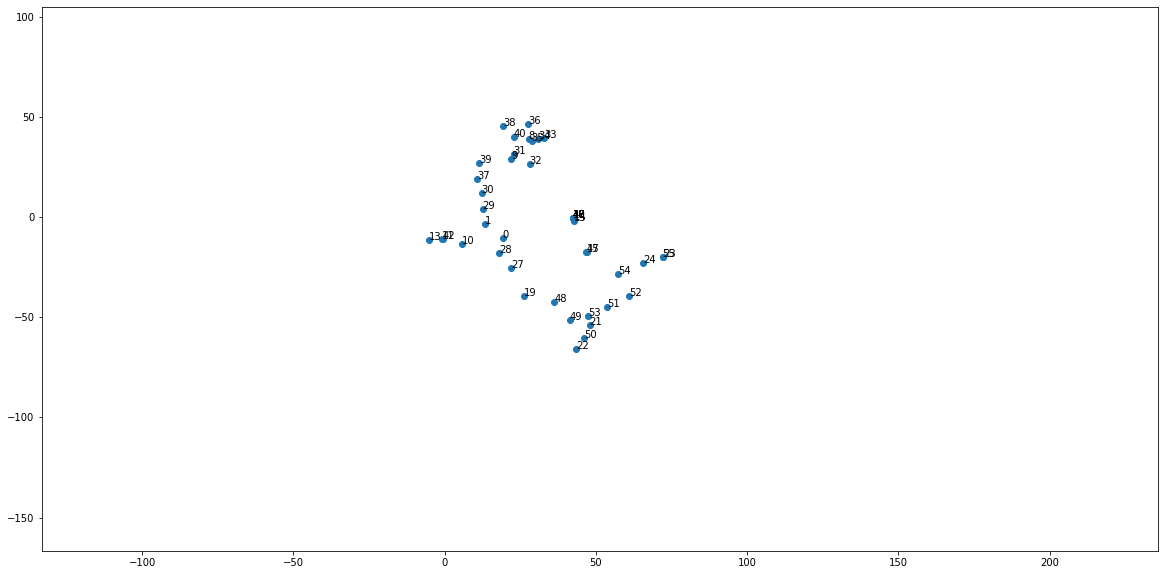

In [859]:
def extract_map(pos=None):
    if pos is None:
        pos = positions
    x = [
        pos[device, 0]
        for device in devices
        if not np.isnan(pos[device, 0])
    ]
    y = [
        pos[device, 1]
        for device in devices
        if not np.isnan(pos[device, 0])
    ]
    devs = [
        device
        for device in devices
        if not np.isnan(pos[device, 0])
    ]
    return x, y, devs

x, y, devs = extract_map(all_pos[0])
def update_map(num):
    pos = all_pos[num]
    x,y, devs = extract_map(pos)
    a = list(zip(x, y))
    scatter.set_offsets(a)
    for idx, a in enumerate(annots):
        a.set_x(x[idx])
        a.set_y(y[idx])
        
    return [scatter] + annots

num_steps = 100

fig = plt.figure(figsize=(20,10))
#ax = fig.add_subplot()

annots = []
for i, label in enumerate(devs):
    annots.append(plt.annotate(str(label), (x[i], y[i])))
    
scatter = plt.scatter(x, y)

# Creating the Animation object
ani = animation.FuncAnimation(
    fig, update_map, range(100), blit=True, interval=100)

from IPython.display import HTML
HTML(ani.to_html5_video())

32724.188723742962
32008.27378216386
6456.666665196419
5834.576840505004
5826.375401057303
5820.725998805836
5818.220983873121
5816.964551389683
5816.556663580239
5815.775454604067
5815.564030060545
5815.507070155814
5815.211667474359
5814.017339066602
5813.561098990496
5813.433610327542
5812.959527204279
5812.854755128268
5812.797449478414
5812.537850448396
5812.50976700522


/tmp/ipykernel_181985/2682579350.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



5812.335345209576


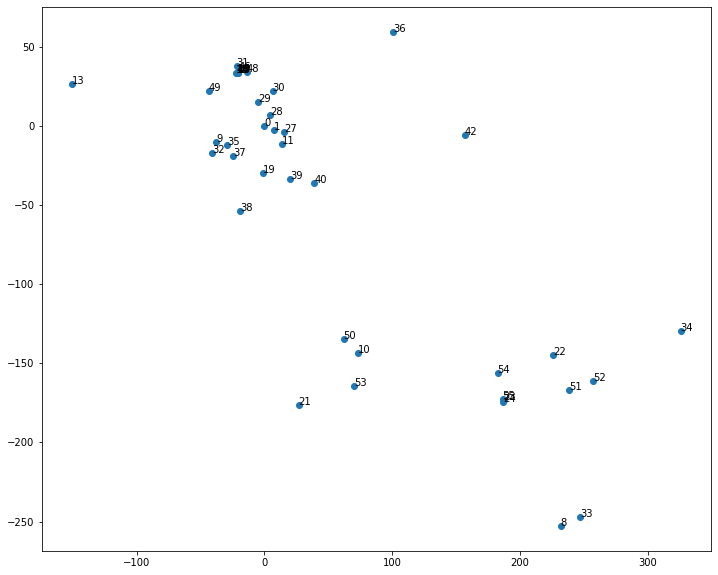

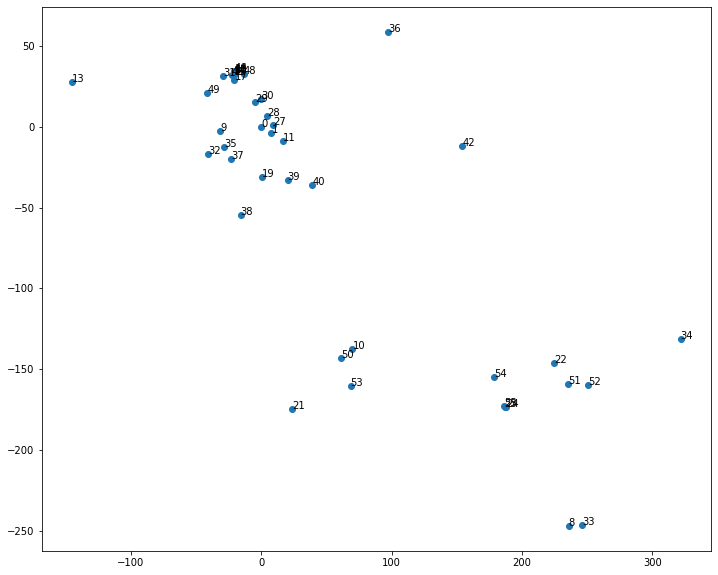

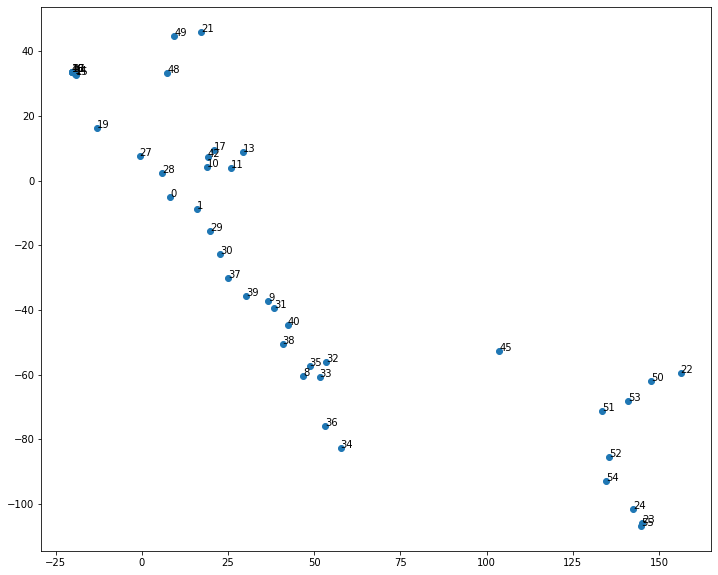

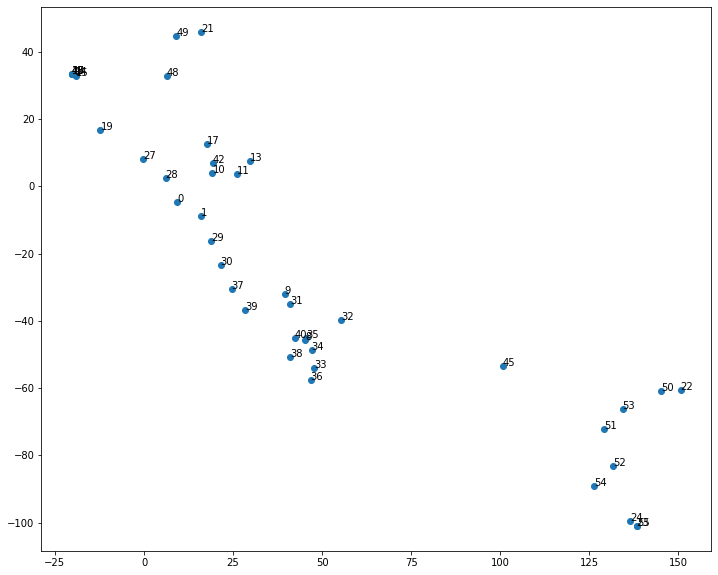

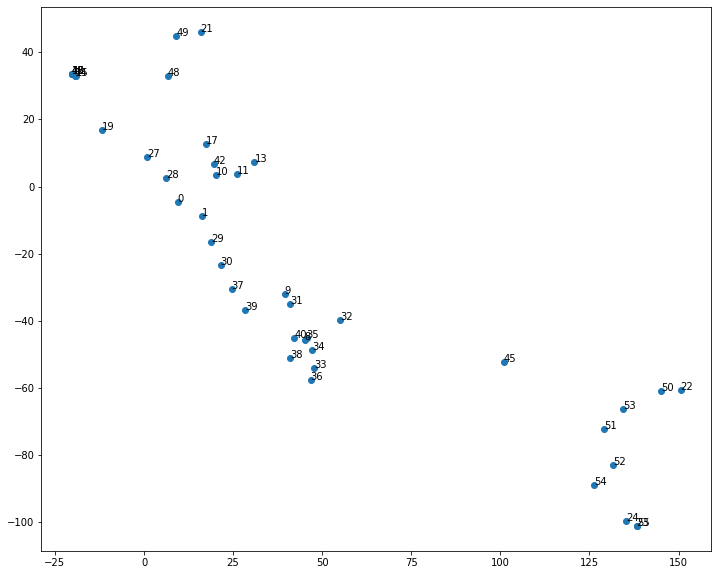

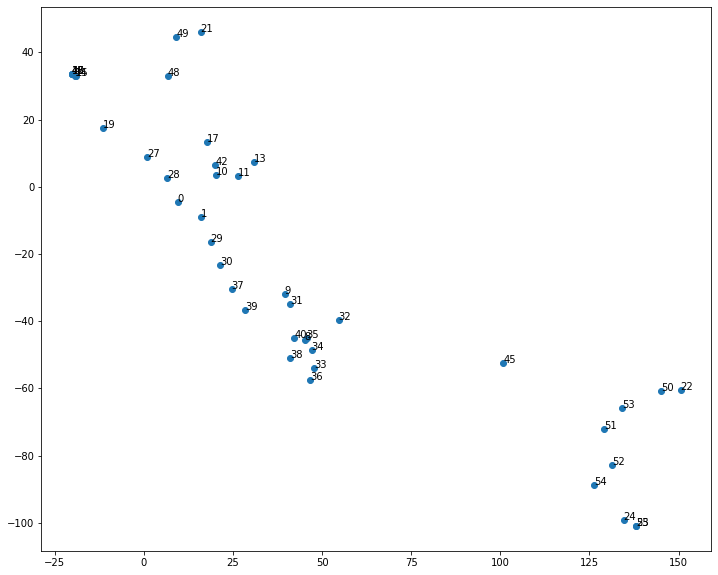

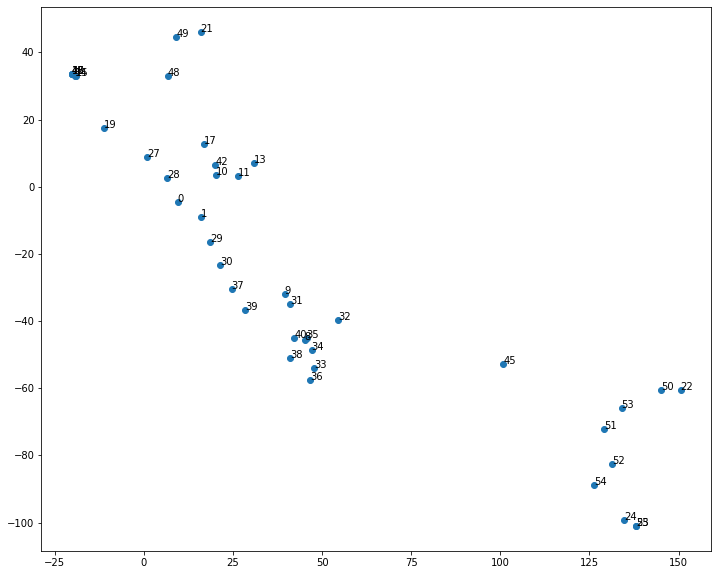

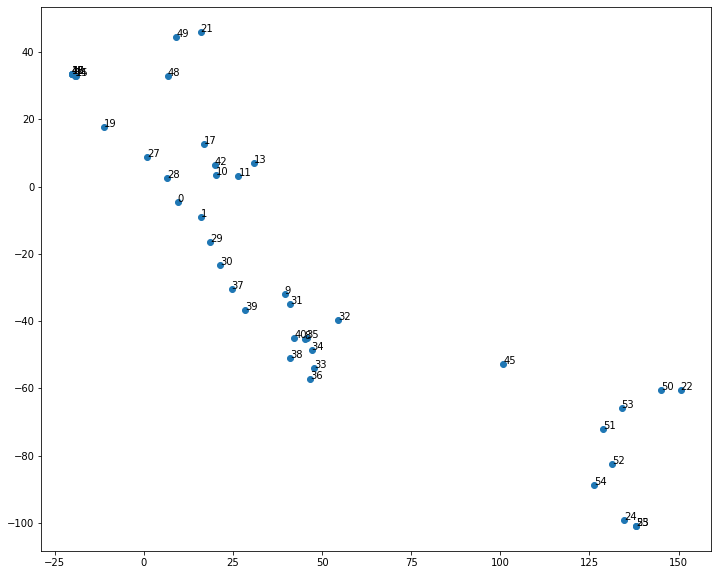

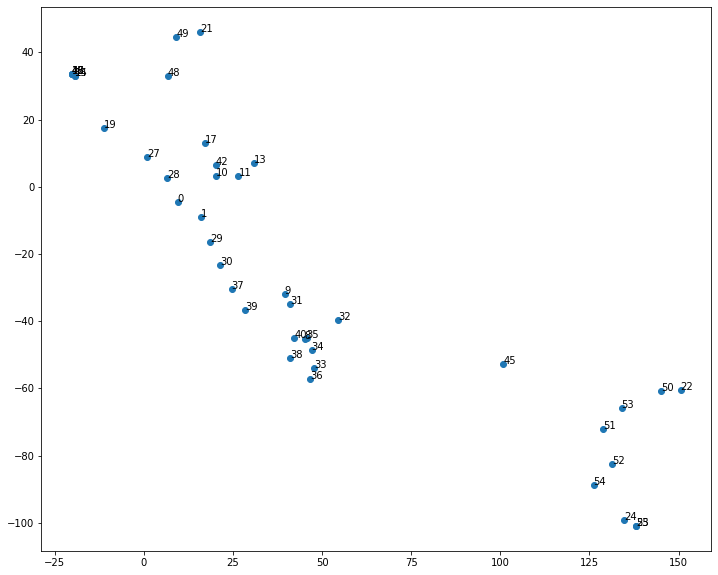

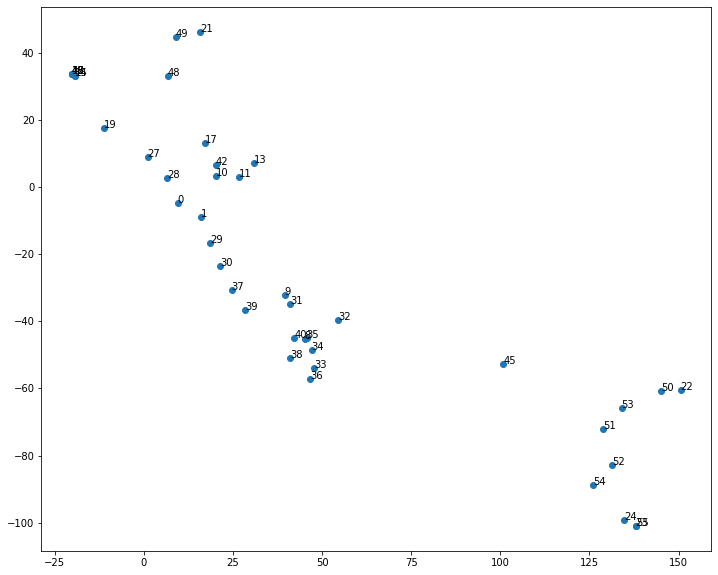

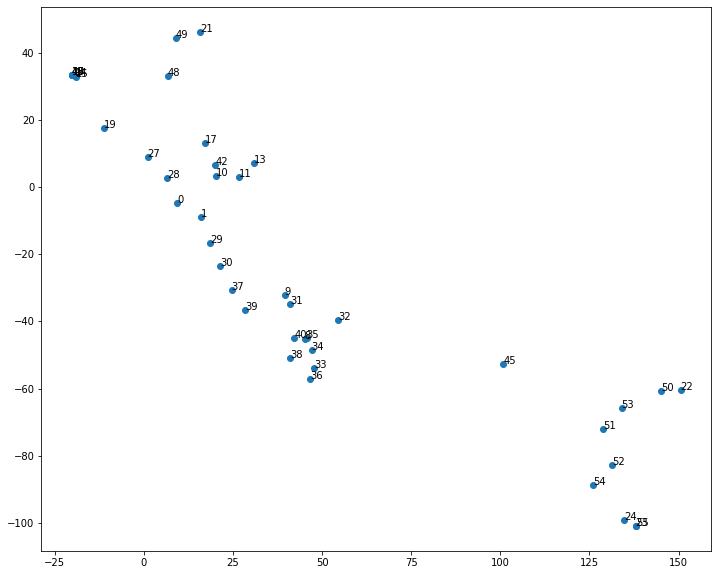

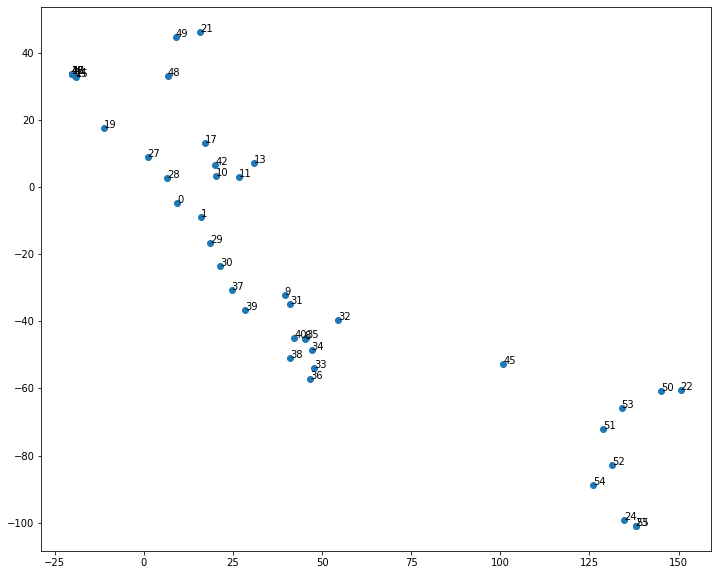

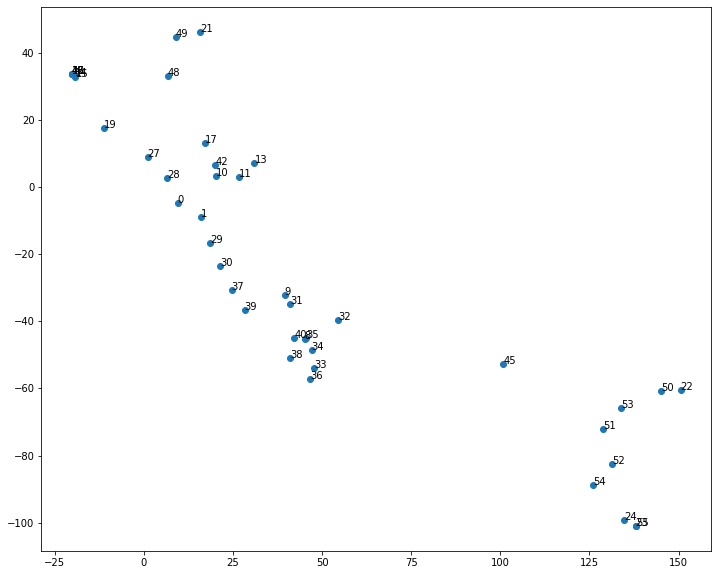

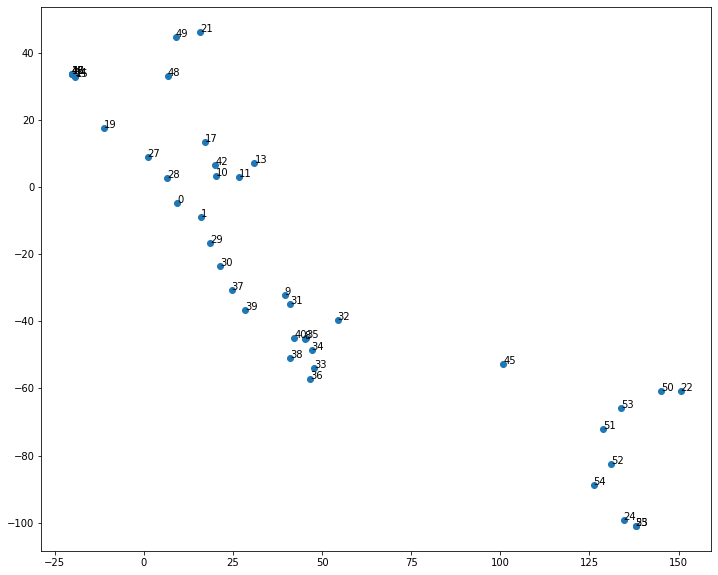

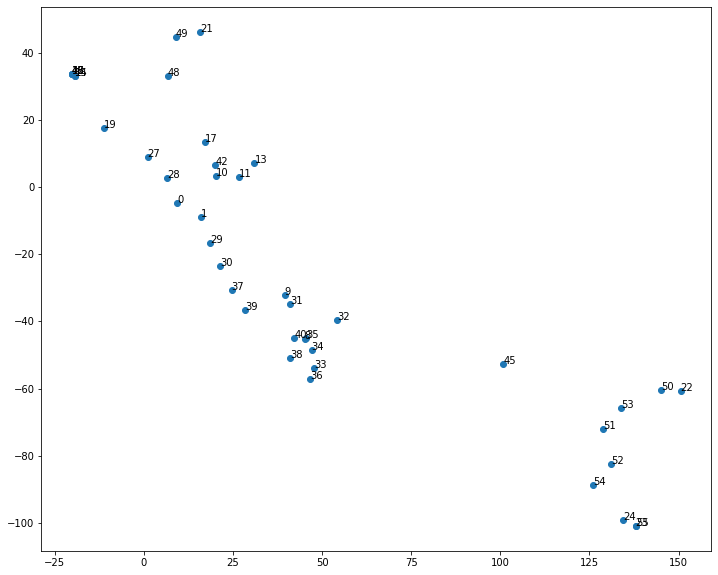

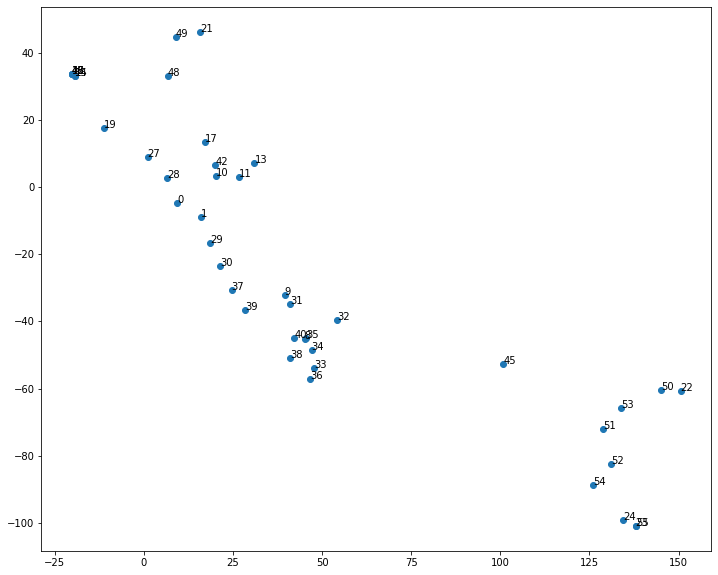

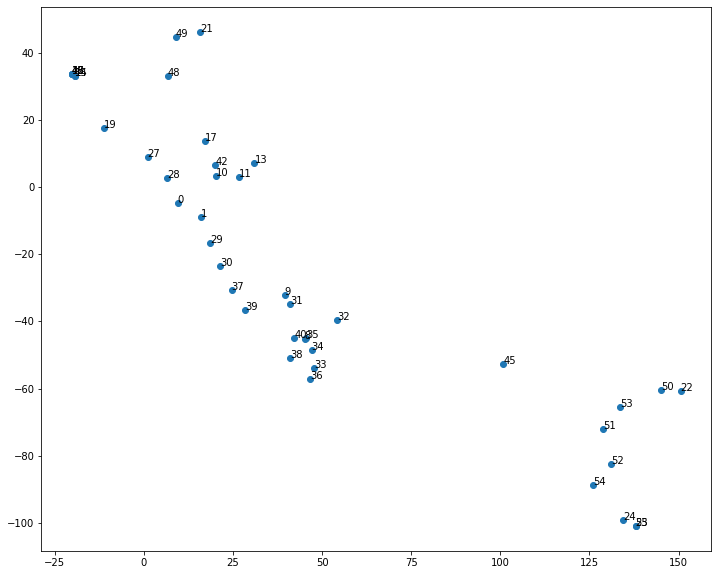

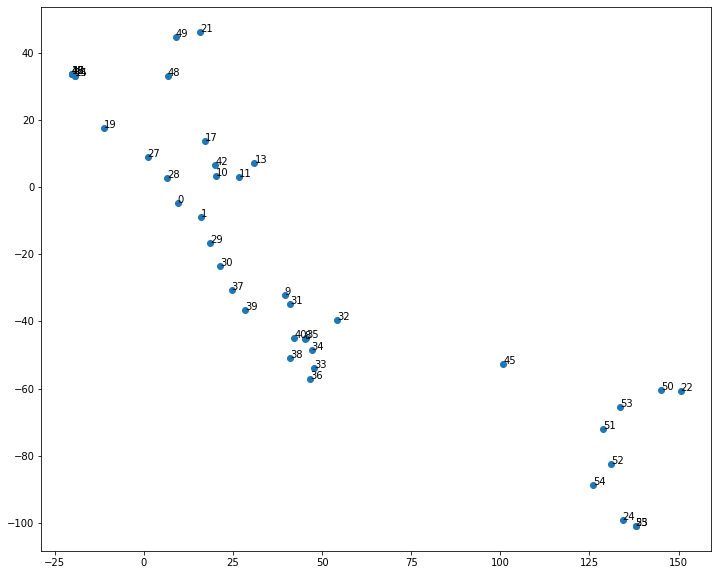

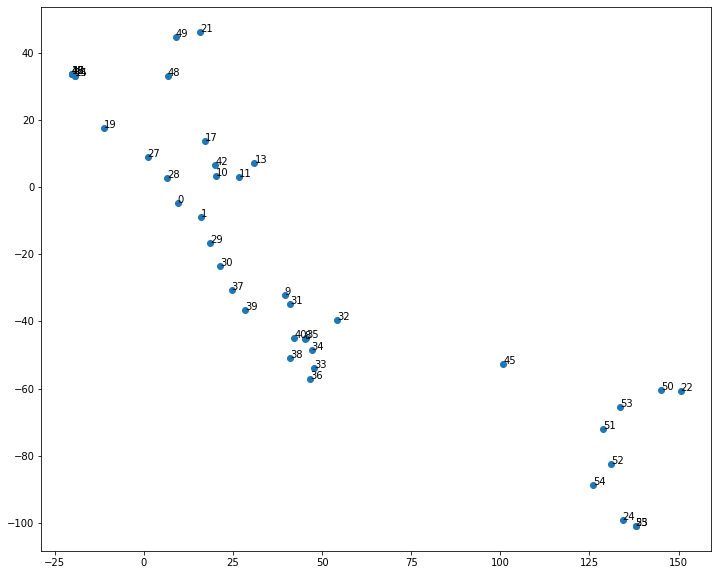

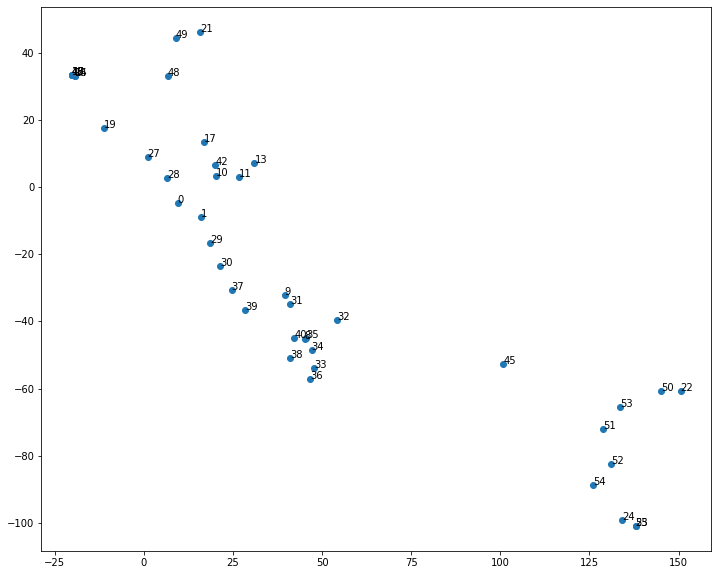

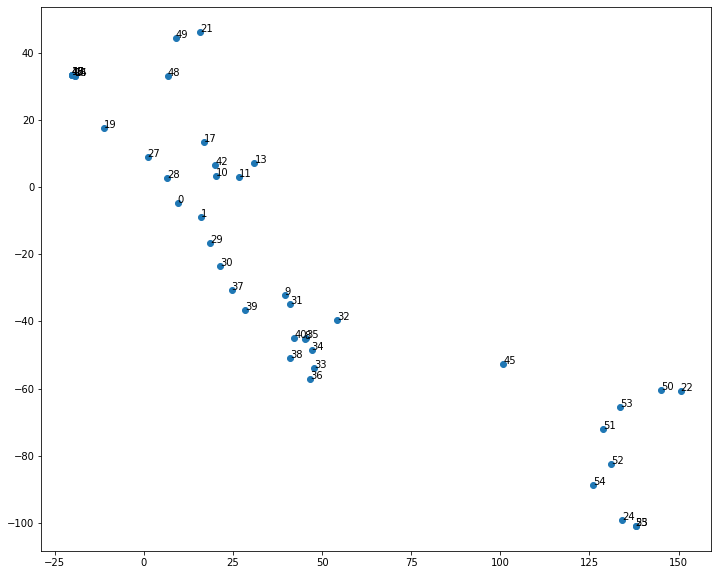

In [787]:
print(measure_total_distance())
draw_plot()
for i in range(2000):
    new_distance = iterate_a_round(iter_num=i)
    if i % 100 == 0:
        print(measure_total_distance())
        draw_plot()
print(measure_total_distance())

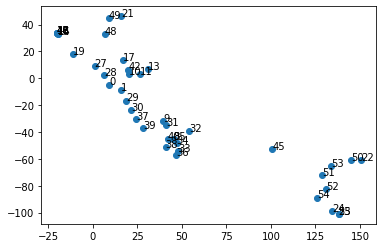

In [789]:
def draw_plot():
    fig, axes = plt.subplots(figsize=(12,10))
    x = [
        positions[device, 0]
        for device in devices
        if not np.isnan(positions[device, 0])
    ]
    y = [
        positions[device, 1]
        for device in devices
        if not np.isnan(positions[device, 0])
    ]
    devs = [
        device
        for device in devices
        if not np.isnan(positions[device, 0])
    ]

    for i, label in enumerate(devs):
        plt.annotate(str(label), (x[i], y[i]))
    plt.scatter(x, y)
draw_plot()
#plt.show()
#mplcursors.cursor(hover=True)
#plt.show()

In [496]:
knn = KNN(k=1)
knn_distances = knn.fit_transform(nan_distances)
knn_distances

Imputing row 1/56 with 37 missing, elapsed time: 0.001
[KNN] Warning: 1636/3136 still missing after imputation, replacing with 0


array([[43.,  7.,  0., ..., 17., 44.,  0.],
       [ 7.,  7.,  0., ...,  8., 17.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [15.,  7.,  0., ...,  8., 21.,  0.],
       [36., 47.,  0., ..., 21., 17.,  0.],
       [ 0.,  0.,  0., ..., 21.,  8.,  0.]], dtype=float32)

In [507]:
np.sum(soft_imputed == 0)

569

In [23]:
devices = sorted(list(df_events.deviceid.unique()))
devices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55]

## Start custom solution

In [ ]:
#Add hour, minute and second of the day to df
def datetime64_to_time_of_day(datetime64_array):
    """
    Return a new array. For every element in datetime64_array return the time of day (since midnight).
    >>> datetime64_to_time_of_day(np.array(['2012-01-02T01:01:01.001Z'],dtype='datetime64[ms]'))
    array([3661001], dtype='timedelta64[ms]')
    >>> datetime64_to_time_of_day(np.datetime64('2012-01-02T01:01:01.001Z','[ms]'))
    numpy.timedelta64(3661001,'ms')
    """
    day = datetime64_array.astype('datetime64[D]').astype(datetime64_array.dtype)
    time_of_day = datetime64_array - day
    return time_of_day
df_events['time_of_day'] = datetime64_to_time_of_day(df_events['timestamp'])
df_events['hour_of_day'] = df_events['time_of_day'] / np.timedelta64(1, 'h')

In [ ]:
# Unique list of all sensors
sensor_names = df_events['deviceid'].unique()

In [ ]:
print(df_events.shape)
event_list = list(df_events.to_records(index=False))


In [ ]:
# Histogram of events per hour

timestamps = [datetime64_to_time_of_day(x[0])/(1e9*60*60) for x in event_list]
fig = go.Figure(data=[go.Histogram(x=timestamps)])
fig.show()

In [ ]:

def get_edges(event_list, time_window_s='5'):
    edges = {}
    time_window = pd.Timedelta(f'{time_window_s}s')
    for i in range(len(event_list)):
        if i % 1000 == 0:
            print(i)
        event = event_list[i]
        timestamp = event[0]
        node = event[1]
        for j in range(i+1, len(event_list)):
            other_event = event_list[j]
            other_timestamp = other_event[0]
            other_node = other_event[1]
            if node == other_node:
                continue
            time_difference = other_timestamp - timestamp
            if time_difference > time_window:
                break
            # Check if other_timestamp is within time_window
            edgelist = edges.get((min(node, other_node), max(node, other_node)), [])
            edgelist.append(time_difference.astype(np.float32)/1e9)
            edges[(min(node, other_node), max(node, other_node))] = edgelist
    return edges

edges = get_edges(event_list)

In [ ]:
i = 0
for key, values in edges.items():
    if key[0] == 17:
        print(key, len(values))
    i += 1

In [ ]:
edge_freq_list = [ (k, (len(v), np.median(v), np.std(v))) for k, v in edges.items() ]
len(edge_freq_list)

In [479]:
# Histogram of standard deviations
sdtdevs = [v[2] for k, v in edge_freq_list]
fig = go.Figure(data=[go.Histogram(x=sdtdevs)])
fig.show()

NameError: name 'edge_freq_list' is not defined

In [ ]:
# Histogram of number of events per pair of nodes
sdtdevs = [v[0] for k, v in edge_freq_list]
fig = go.Figure(data=[go.Histogram(x=sdtdevs, nbinsx=5000)])
fig.show()

In [ ]:
# Histogram of distance for most common edge
sorted_edge_freq_list = sorted(edge_freq_list, key=lambda x: x[1][0], reverse=True)
most_common_edge = edge_freq_list[0][0]
edge_distances = edges[most_common_edge]
fig = go.Figure(data=[go.Histogram(x=edge_distances)])
fig.show()


In [ ]:
# Discard edges where the std dev is larger than 0.5 of the std dev of the uniform distribution
stddev_uniform = time_window.seconds / np.sqrt(12)
print('len before', len(edge_freq_list))
edge_freq_list_filtered1 = [ (k, v) for (k, v) in edge_freq_list if v[2] < stddev_uniform * 0.8 ]
print('len after', len(edge_freq_list_filtered1))


In [ ]:
# Discard edges where the number of events is smaller than 100
print('len before', len(edge_freq_list))
edge_freq_list_filtered2 = [ (k, v) for (k, v) in edge_freq_list if v[0] > 100 ]
print('len after', len(edge_freq_list_filtered2))

sdtdevs = [v[2] for k, v in edge_freq_list_filtered2]
fig = go.Figure(data=[go.Histogram(x=sdtdevs)])
fig.show()


In [ ]:
def get_network(edge_freq_list):
    net = Network()

    added_elements = []

    # for device in sensor_names:
    #     net.add_node(str(device))

    for element in edge_freq_list:
        node1, node2 = element[0]
        if node1 not in added_elements:
            net.add_node(str(node1))
            added_elements.append(node1)
        if node2 not in added_elements:
            net.add_node(str(node2))
            added_elements.append(node2)
        strength = element[1][0]
        variance = round(element[1][2],2)
        distance = round(element[1][1],2)
        net.add_edge(str(node1), str(node2), value=element[1][0], length=distance*300, label=f"s:{strength},d: {distance},v: {variance}")

    net.show('network.html')

get_network(edge_freq_list_filtered2)

In [478]:
print(edges[(2, 45)])

NameError: name 'edges' is not defined

## Attempt using only 6-8 AM, 11-12 AM, and 15-17 PM data

In [ ]:
# Attempt using only 6-8 AM, 11-12 AM, and 15-17 PM data
print('prefilter', df_events.shape)
df_events_hourfilter = df_events[(df_events['hour_of_day'] >= 6) & (df_events['hour_of_day'] <= 8) | (df_events['hour_of_day'] >= 11) & (df_events['hour_of_day'] <= 12) | (df_events['hour_of_day'] >= 15) & (df_events['hour_of_day'] <= 17)]
print('postfilter', df_events_hourfilter.shape)
event_list_hourfilter = list(df_events_hourfilter.to_records(index=False))

edges_hourfilter = get_edges(event_list_hourfilter, 3)
edge_freq_list_hourfilter = [ (k, (len(v), np.median(v), np.std(v))) for k, v in edges_hourfilter.items() ]
get_network(edge_freq_list_hourfilter)

In [ ]:
sorted_edge_freq_list_hourfilter = sorted(edge_freq_list_hourfilter, key=lambda x: x[1][0], reverse=True)

get_network(sorted_edge_freq_list_hourfilter[:100])

## Now checking connection when going through third node
The logic here is to find and remove edges that connect nodes that actually have a node in between. Say in reality the path is A->B->C, then we want to have edges A->B and B->C. We want to remove the edge A->C. Maybe we can do this by, given a pair of nodes X and Y, we check if we have an edges X->Z and Z->Y with similar strenght, and the distance matches. If so, we remove X->Y. 

In [ ]:

def get_edges_path(event_list, time_window_s=5, node_chain_length=2):

    edges = {}
    time_window = pd.Timedelta(f'{time_window_s}s')
    for i in range(len(event_list)):
        if i % 1000 == 0:
            print(i)
        event = event_list[i]
        timestamp = event[0]
        node_id = event[1]
        prev_node_id = node_id
        node_chain = [(node_id, timestamp)]

        for j in range(i+1, len(event_list)):
            if len(node_chain) >= node_chain_length:
                break
            other_event = event_list[j]
            other_timestamp = other_event[0]
            other_node = other_event[1]
            if prev_node_id == other_node:
                continue
            time_difference = other_timestamp - timestamp
            if time_difference > time_window:
                break
            node_chain.append((other_node, other_timestamp))
            prev_node_id = other_node
        

            

    return edges

edges = get_edges(event_list)

## Multidimensional Scaling approach

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [ ]:
# Fake data
EPSILON = np.finfo(np.float32).eps
n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(float)
X_true = X_true.reshape((n_samples, 2))
# Center the data
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise


In [ ]:
# Real data
matrix_size = len(sensor_names)
#Generate empty matrix of size matrix_size
similarities = np.zeros((matrix_size, matrix_size))
similarities[:] = 7
# Set the diagonal to 0
for i in range(len(sensor_names)):
   similarities[i,i] = 0

# edge_freq_list: all edges
# edge_freq_list_hourfilter: only includes events that occur in 6-8 AM, 11-12 AM, and 15-17 PM
for i in range(len(edge_freq_list_hourfilter)):
    if i % 100 == 0:
        print(i)
    edge = edge_freq_list[i]
    node1 = edge[0][0]
    node2 = edge[0][1]
    strength = edge[1][0]
    distance = edge[1][1]
    variance = edge[1][2]
    if strength > 100:
        similarities[node1][node2] = distance
        similarities[node2][node1] = distance


In [ ]:
print(similarities)

In [ ]:
# Do MDS

# mds = manifold.MDS(
#     n_components=2,
#     max_iter=30000,
#     eps=1e-9,
#     random_state=seed,
#     dissimilarity="precomputed",
#     n_jobs=1,
# )
# pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(
    n_components=2,
    metric=False,
    max_iter=3000,
    eps=1e-12,
    dissimilarity="precomputed",
    random_state=seed,
    n_jobs=1,
)
npos = nmds.fit(similarities).embedding_
# npos = nmds.fit_transform(similarities)

# Rescale the data
# pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)

# pos = clf.fit_transform(pos)

npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

s = 100
# plt.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label="NMDS")
plt.legend(scatterpoints=1, loc="best", shadow=False)

for i, label in enumerate(sensor_names):
    plt.annotate(label, npos[i])

similarities_2 = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities_2, 0)
# Plot the edges
start_idx, end_idx = np.where(npos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
values = np.abs(similarities_2)

plt.show()

In [ ]:
print(pos)

## End custom solution

In [ ]:
df_devices = pd.read_json(f'./data/{site}/{site}.json')

In [ ]:
df_devices.head(5)

In [ ]:
with open(f'./data/{site}/{site}.png', "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()

In [ ]:
img = iio.imread(f'./data/{site}/{site}.png')
img.shape

We can now load the floorplan just to get a feel of what the devices look like.

In [ ]:
scaling_factor = 3 # Set to 1 for highest resolution
plotting_obj = Plotting(bg_img=encoded_string, dims=(img.shape[1], img.shape[0]), df_devices=df_devices, scaling_factor=scaling_factor)
plotting_obj.run(renderer='browser') # Switch to iframe if you would like to view it here

## View Occupancy by Day
<p>Since we are dealing with irregular IoT event data, we need to define our time-series window size and compute a statistic for the events during that window. This example shows the sum of events per day. </p>

In [ ]:
df_events_day = df_events.copy()
df_events_day.loc[:, 'timestamp'] = df_events_day['timestamp'].dt.floor('1D')
df_events_day.loc[:, 'value'] = 1.0
df_events_day = df_events_day.groupby('timestamp').sum()
df_events_day = df_events_day.drop(['deviceid'], axis=1)
df_events_day = df_events_day.reindex(pd.date_range(df_events_day.index.min(), df_events_day.index.max(), freq='1D')).fillna(0)

In [ ]:
df_events_day.head(5)

In [ ]:
fig = go.Figure(data=[go.Scatter(x=df_events_day.index, y=df_events_day['value'])],
                layout=dict(height=500, width=1000))
fig.show()

## Animate Data

<p>The plotting helper script contains an animation engine utilising Plotly. It is extremely simple to use. Here is an example where we aggregate data into 5 minute bins, and then visualize how motion sensors are triggered through 1 day. You can choose different time intervals, but please remember that higher time granularities can end up rendering a lot of frames and might lead to performance issues. In this example, the total number of frames is (60//5) * 24 = 288</p>

In [ ]:
df_events_day = df_events[df_events.timestamp.dt.date.astype(str) == "2021-08-05"].copy()
df_events_day.timestamp = df_events_day.timestamp.dt.floor('1min')
df_events_day.loc[:, 'b'] = 1
df_events_day = df_events_day.groupby(['deviceid', 'timestamp']).sum()
df_events_day = df_events_day.pivot_table(index='timestamp', columns='deviceid', values='b')
df_events_day = df_events_day.reindex(pd.date_range(df_events_day.index.min().floor('1D'), df_events_day.index.max().ceil('1D'), freq='1min', closed='left')).fillna(0)

In [ ]:
frames = df_events_day.to_dict(orient='records')
ts = df_events_day.reset_index()[['index']].astype(str).to_dict(orient='records')

In [ ]:
df_events_day[df_events_day[0] > 0]


In [ ]:
plotting_obj = Plotting(bg_img=encoded_string, dims=(img.shape[1], img.shape[0]), df_devices=df_devices, scaling_factor=3)
plotting_obj.populate_data(frames, ts)
plotting_obj.run(renderer='browser')

## Challenge Category 1
<p>For the first challenge, we want to solve a real-world problem of indoor device mapping. The floorplans we have provided you with already contain mapped devices, meaning they have defined locations on a floorplan. In reality, this takes a lot of time. We physically need to identify each device inside the building and place them on a floorplan. The objective of this exercise is to come up with ways to speed up this process. We have written down some ideas below, however feel free to be creative! You can come up with entirely new ideas of your own.</p>

#### Example Aproach:
<p>Let's assume the floorplan contains 500 devices. We can delete 400 devices, and use the occupancy events data to identify neighbours. Once the neighbours have been identified, we can simply use the data to locate the missing 400 devices! This means our engineers only need to locate 100 devices, and let the system run for N days and then find the rest.</p> 
<p>The Machine Learning aspect of the challenge comes from: 1. increasing the number of deleted devices, and 2. the smallest possible value of N that gives the best mappings. You can use Euclidean distance between the predicted location of the object and the actual location from our provided floorplans to determine accuracy of your algorithm. We have provided 5 different sites with a variety of device configurations and data, so be sure to properly create Training and Test Datasets!</p>


## Challenge Category 2
<p>The second challenge is more about providing value to the client. We have provided data from real-world buildings. These buildings are occupied according to certain predictable patterns. For example a school might only observe occupancy during the morning. A hospital or a shopping mall might observe occupancy throughout the day. The objective of this exercise is to determine how people move through buildings by combining spatial and temporal data. </p>

#### Example Aproach:
<p>We can define a graph network of devices, with the edge weights representing the distance between devices. Then depending on the proximity of devices and the correlation of events within a certain time-window, say 15 minutes, we can cluster the most frequently visited spaces in a building. By creating similar sequences across the day, week or month we can determine patterns that show us how the building is used at different times of the day, or different days of the week etc. We can also try to figure out which paths are dominant and which are used least frequently. Such information is extremely valuable to building owners and tenants.</p> 
<p>You can experiment with different windowing approaches. Try to think about what sort of metrics are important. Is it really worth investigaing how the occupancy changes at midnight, or is it worth understanding how people move through the building at 9AM? Also, does the pattern change during the week, for example do more people visit on Monday or Friday?</p>
<p>We would love to see your ideas on what is the best way to present the results of this type of data analysis to the customers. UI/UX experts, we're looking at you!</p>


## Challenge Category 3
<p>The last challenge is related to a type of sensor that is not common in smart buildings at the moment: audio sensors. We have availabe motion sensors that generate occupancy data, but we decided to augmnet that with audio data. We want to explore the utility of incorporating more data sources in a smart building.</p>
<p>The data collection is done at a garage, and contains 4 audio sensors placed in a rectangular grid. There is a lot of activity happening in the garage: people are walking, driving their car, or bicycles. The objective would be to identify these events by combining the audio streams from all the 4 sensors and by incorporating motion data to pinpoint where the activity was taking place.</p>

#### Example Aproach:
<p>This is an extremely open ended challenge. There are numerous ways this can be tackled. Clever audio signal processing, or using deep learning to detect events. The choice is yours.</p> 